#Import libraries and input data

In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM 
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from scipy.stats import spearmanr
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.linear_model import LinearRegression

from pathlib import Path
results_path = Path('results', 'MSFT')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [ ]:
#Input fixed_period_extraction_day
data_df=pd.read_csv('fixed_period_extraction_day.csv',index_col='Datetime')
print(data_df.shape)
data_df

(3272, 1)


,Range
Datetime,
2010-01-04,0.389279
2010-01-05,0.351115
2010-01-06,0.427443
2010-01-07,0.389279
2010-01-08,0.488507
...,...
2022-12-23,4.917675
2022-12-27,3.092246
2022-12-28,5.536136


#LSTM datasets generation

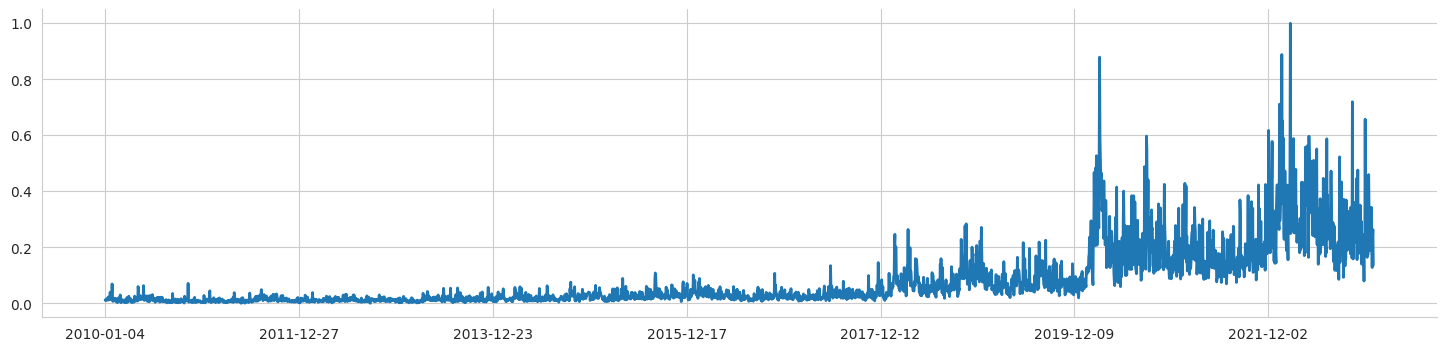

In [ ]:
#Step 1 Scale date:Use whole dataset fitting MinMaxScaler
data_set=data_df.iloc[:, :].values
scaler = MinMaxScaler(feature_range = (0, 1))
data_set_scaled=scaler.fit_transform(data_set)

##Create data_df_scaled from data_set_scaled and plot data_df_scaled
data_df_scaled= pd.Series(data_set_scaled.squeeze(), index=data_df.index)
data_df_scaled.shape

sns.set_style('whitegrid')
ax = data_df_scaled.plot(lw=2, figsize=(18, 4), rot=0)
ax.set_xlabel('')
sns.despine()


In [ ]:
#Step 2 Create input/output sequences for LSTM
def create_univariate_rnn_data(data, window_size):#THe Dtype of data is DataFrame 
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

##setting window_size
window_size = 64
## Create X,y
X, y = create_univariate_rnn_data(data_df_scaled, window_size=window_size)
print(X.shape,y.shape)

(3208, 64) (3208,)


In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
Datetime,,,,,,,,,,,,,,,,,,,,,
2010-04-07,0.011632,0.009994,0.013271,0.011632,0.015892,0.015892,0.010977,0.011632,0.022447,0.012288,...,0.011052,0.003150,0.020271,0.015003,0.003809,0.006772,0.013027,0.025209,0.008089,0.014674
2010-04-08,0.009994,0.013271,0.011632,0.015892,0.015892,0.010977,0.011632,0.022447,0.012288,0.013271,...,0.003150,0.020271,0.015003,0.003809,0.006772,0.013027,0.025209,0.008089,0.014674,0.008747
2010-04-09,0.013271,0.011632,0.015892,0.015892,0.010977,0.011632,0.022447,0.012288,0.013271,0.015565,...,0.020271,0.015003,0.003809,0.006772,0.013027,0.025209,0.008089,0.014674,0.008747,0.017308
2010-04-12,0.011632,0.015892,0.015892,0.010977,0.011632,0.022447,0.012288,0.013271,0.015565,0.018514,...,0.015003,0.003809,0.006772,0.013027,0.025209,0.008089,0.014674,0.008747,0.017308,0.011710
2010-04-13,0.015892,0.015892,0.010977,0.011632,0.022447,0.012288,0.013271,0.015565,0.018514,0.039487,...,0.003809,0.006772,0.013027,0.025209,0.008089,0.014674,0.008747,0.017308,0.011710,0.004138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.248164,0.189230,0.306670,0.319482,0.231508,0.328450,0.291723,0.224675,0.271651,0.176845,...,0.172647,0.224894,0.459581,0.349518,0.288705,0.266007,0.273288,0.187208,0.230890,0.342666
2022-12-27,0.189230,0.306670,0.319482,0.231508,0.328450,0.291723,0.224675,0.271651,0.176845,0.342970,...,0.224894,0.459581,0.349518,0.288705,0.266007,0.273288,0.187208,0.230890,0.342666,0.206051
2022-12-28,0.306670,0.319482,0.231508,0.328450,0.291723,0.224675,0.271651,0.176845,0.342970,0.329304,...,0.459581,0.349518,0.288705,0.266007,0.273288,0.187208,0.230890,0.342666,0.206051,0.127679


In [ ]:
y

Datetime
2010-04-07    0.008747
2010-04-08    0.017308
2010-04-09    0.011710
2010-04-12    0.004138
2010-04-13    0.007101
                ...   
2022-12-23    0.206051
2022-12-27    0.127679
2022-12-28    0.232603
2022-12-29    0.263438
2022-12-30    0.136245
Length: 3208, dtype: float64

In [ ]:
# Step 3: To respect the time series nature of the data, set aside the data at the end of the sample as a hold-out or test set

# Set split dates
split_date_train = '2020-12-31'
split_date_test = '2021-01-01'

# Select training data and reshape it for LSTM
X_train = X[:split_date_train].values.reshape(-1, window_size, 1) 
y_train = y[:split_date_train]

# Select testing data and reshape it for LSTM
X_test = X[split_date_test:].values.reshape(-1, window_size, 1) 
y_test = y[split_date_test:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(2705, 64, 1) (2705,)
(503, 64, 1) (503,)


# LSTM model(10 Unites)

##Define LSTM model architecture
Use Keras to quickly build a two hidden layer LSTM networks of the following specifications:
*   Layer 1 uses an LSTM module with 10 hidden units
*   Layer 2 uses a fully connected module with one unit.
*   The loss function is  'mean_squared_error'for this regression problem
*   Using the RMSProp optimizer recommended for RNN with default settings

In [ ]:
# Define create_model function
def create_model(units):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(X_train.shape[1], X_train.shape[2]),name='LSTM'))
    model.add(Dense(1,name='Output'))
    #optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [ ]:
#Create model_lstm
model_lstm=create_model(units=10)

##Shows the number of the model_lstm parameters
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None


##Train LSTM model

In [ ]:
#Step 1 Create lstm.h5
lstm_path = (results_path / 'lstm_10units.h5').as_posix()

#Step 2 Create checkpointer
checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

#Step 3 Define an EarlyStopping callback and train the model for up to 100 episodes.
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=5,
                              restore_best_weights=True)

#Step 4 Train LSTM Model
lstm_training = model_lstm.fit(X_train,
                          y_train,
                          epochs=100,
                          batch_size=20,
                          shuffle=True,
                          validation_data=(X_test, y_test),
                          callbacks=[early_stopping, checkpointer],
                          verbose=1)

Epoch 1/100
135/136 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 1: val_loss improved from inf to 0.01098, saving model to results/MSFT/lstm.h5
136/136 [==============================] - 15s 63ms/step - loss: 0.0022 - val_loss: 0.0110
Epoch 2/100
136/136 [==============================] - ETA: 0s - loss: 0.0013
Epoch 2: val_loss improved from 0.01098 to 0.01096, saving model to results/MSFT/lstm.h5
136/136 [==============================] - 8s 59ms/step - loss: 0.0013 - val_loss: 0.0110
Epoch 3/100
135/136 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 3: val_loss did not improve from 0.01096
136/136 [==============================] - 8s 55ms/step - loss: 0.0013 - val_loss: 0.0113
Epoch 4/100
135/136 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 4: val_loss improved from 0.01096 to 0.01092, saving model to results/MSFT/lstm.h5
136/136 [==============================] - 6s 43ms/step - loss: 0.0013 - val_loss: 0.0109
Epoch 5/100
135/1

##Evaluate performance

In [ ]:
# Define plot_rmse function
def plot_rmse(model_training,filename='lstm_msft_error'):
  fig, ax = plt.subplots(figsize=(12, 4))

  loss_history = pd.DataFrame(model_training.history).pow(.5)#taking the square root of each element.
  loss_history.index += 1

  best_rmse = loss_history.val_loss.min()
  best_epoch = loss_history.val_loss.idxmin()
  print('Best_epoch:',best_epoch)

  title = f'Epoch RMSE (Best Validation RMSE: {best_rmse:.4%})'
  loss_history.columns=['Training RMSE', 'Validation RMSE']
  loss_history.plot(logy=False, lw=2, title=title, ax=ax)

  ax.axvline(best_epoch, ls='--', lw=1, c='k')
  sns.despine()
  fig.tight_layout()

  fig.savefig(results_path / filename, dpi=300)
  return loss_history

Best_epoch: 6


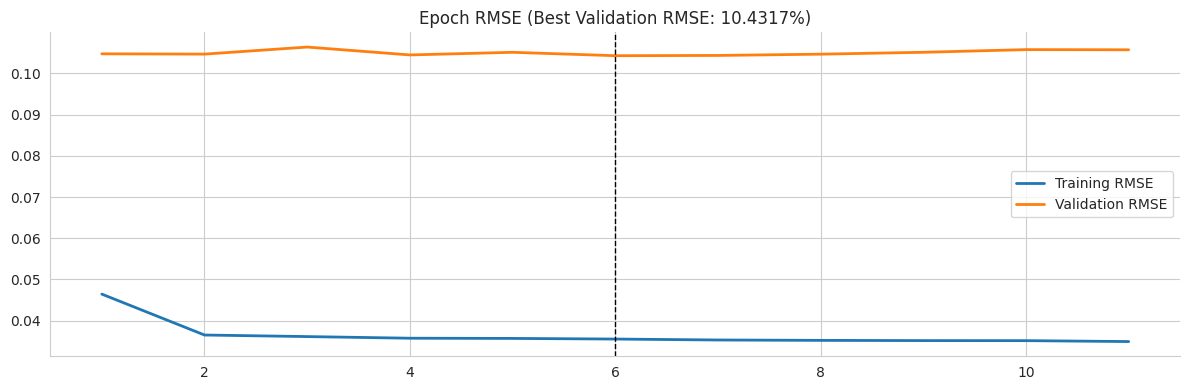

In [ ]:
loss_history=plot_rmse(lstm_training,filename='lstm_msft_error_10units')

In [ ]:
#Outout loss_history_initial.csv and print loss_history
loss_history.to_csv('loss_history_10units.csv')
print(loss_history)

    Training RMSE  Validation RMSE
1        0.046452         0.104774
2        0.036522         0.104700
3        0.036143         0.106414
4        0.035745         0.104502
5        0.035697         0.105138
6        0.035543         0.104317
7        0.035315         0.104377
8        0.035222         0.104687
9        0.035169         0.105143
10       0.035154         0.105794
11       0.034936         0.105751


In [ ]:
#Calculate train_rmse_scaled and test_rmse_scaled
train_rmse_scaled = np.sqrt(model_lstm.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(model_lstm.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0353 | Test RMSE: 0.1043


In [ ]:
#Predict and create train_predict_scaled and test_predict_scaled
train_predict_scaled = model_lstm.predict(X_train)
test_predict_scaled = model_lstm.predict(X_test)

16/16 [==============================] - 0s 7ms/step


In [ ]:
#Calculate train_ic and test_ic
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.8616 | Test IC: 0.6114


##Rescale predictions

In [ ]:
#Rescale train_predict_scaled and test_predict_scaled
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index=y_test.index))

In [ ]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [ ]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}'

'Train RMSE: 0.8227 | Test RMSE: 2.4298'

##Plot Results

In [ ]:
#Create new_data_df
new_data_df=data_df.copy()
new_data_df['Train Predictions'] = train_predict
new_data_df['Test Predictions'] = test_predict

new_data_df = new_data_df.join(train_predict.to_frame('predictions').assign(data='Train')
                        .append(test_predict.to_frame('predictions').assign(data='Test')))

<ipython-input-20-7516f4c70897>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data_df = new_data_df.join(train_predict.to_frame('predictions').assign(data='Train')


<ipython-input-21-152def917281>:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
<ipython-input-21-152def917281>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)


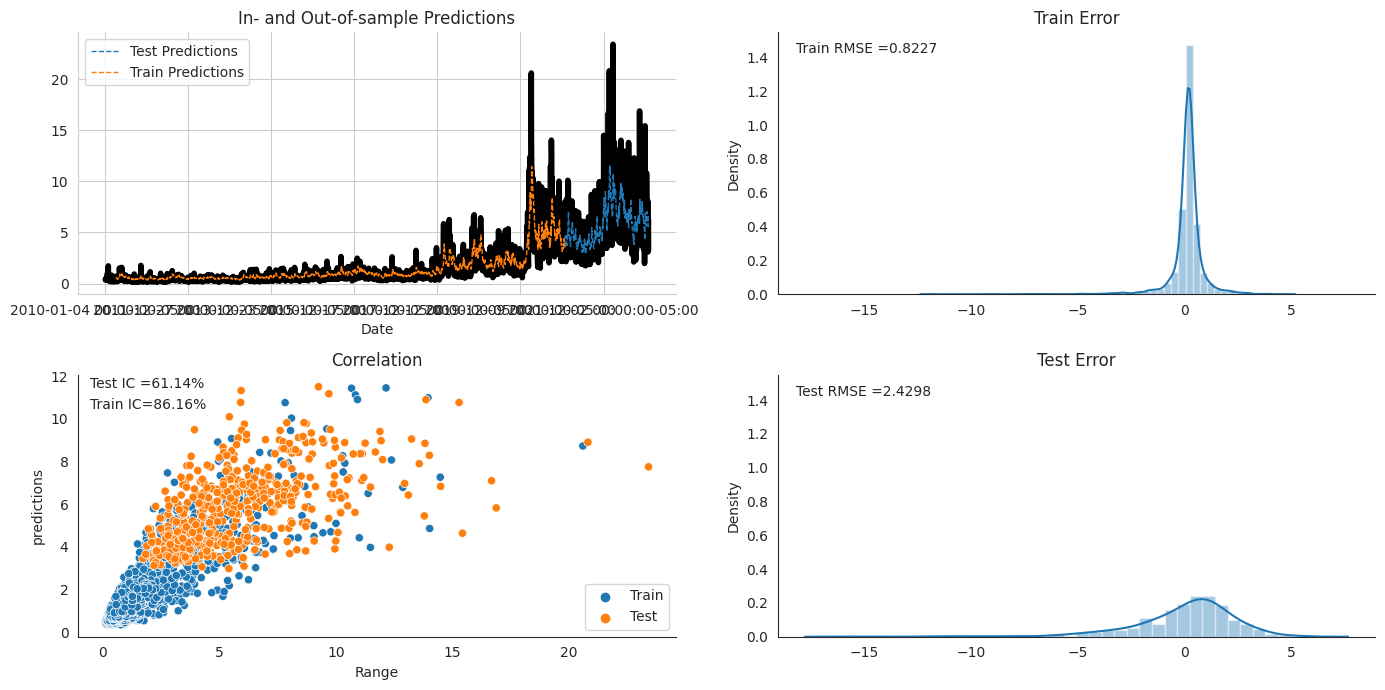

In [ ]:
df=new_data_df.copy()

#Plot results
sns.set_style('whitegrid')
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)
##ax1
df.loc[:, 'Range'].plot(lw=4, ax=ax1, c='k')
df.loc[:, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')
##ax2,3,4
with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Range', y='predictions', data=df, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'lstm_msft_regression_10units', dpi=300)

16/16 [==============================] - 0s 8ms/step


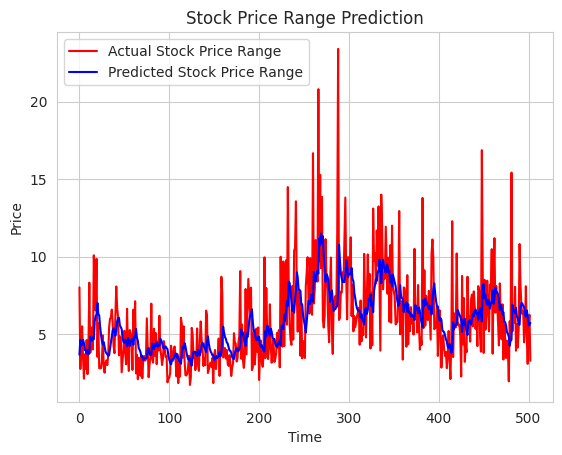

In [ ]:
#Define plot_pred_without_date function
def plot_pred_without_date(model,scaler,X_test,y_test):
  # Make predictions on test data
  predicted_stock_price_range = model.predict(X_test)
  predicted_stock_price_range = scaler.inverse_transform(predicted_stock_price_range)
  actual_stock_price_range=scaler.inverse_transform(y_test.values.reshape(-1, 1))
  # Visualize the results
  plt.plot(actual_stock_price_range, color = 'red', label = 'Actual Stock Price Range')
  plt.plot(predicted_stock_price_range, color = 'blue', label = 'Predicted Stock Price Range')
  plt.title('Stock Price Range Prediction')
  plt.xlabel('Time')
  plt.ylabel('Price')
  plt.legend()
  plt.show()

plot_pred_without_date(model_lstm,scaler,X_test,y_test)

#Tuning parameters 

##Refine version

In [ ]:
# Step 1: Create the KerasRegressor wrapper
keras_regressor = KerasRegressor(build_fn=create_model, epochs=100, batch_size=20, verbose=0)

# Step 2: Define the grid search parameters
units = [10, 20, 30]
param_grid = dict(units=units)

# Step 3: Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=3)

# Step 4: Perform the grid search using TimeSeriesSplit and custom RMSE scorer
grid = GridSearchCV(estimator=keras_regressor, param_grid=param_grid, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')
grid_result = grid.fit(X_train, y_train)

# Step 5: Print the results
print(f"Best RMSE: {-grid_result.best_score_} using {grid_result.best_params_}")


In [ ]:
#Step 1 Create the KerasRegressor wrapper
KerasRegressor = KerasRegressor(build_fn=create_model, epochs=100, batch_size=20, verbose=0)

#Step 2 Define the grid search parameters
units = [10, 20, 30]
#learning_rate = [0.001, 0.01, 0.1]
param_grid = dict(units=units)#, learning_rate=learning_rate)

#Step 3 Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=3)

#Step 4  Perform the grid search using TimeSeriesSplit and custom RMSE scorer
grid = GridSearchCV(estimator=KerasRegressor, param_grid=param_grid, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')
grid_result = grid.fit(X_train, y_train)

#Step 5  Print the results
print("Best RMSE: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))


<ipython-input-23-677e1d7c5cef>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  KerasRegressor = KerasRegressor(build_fn=create_model, epochs=100, batch_size=20, verbose=0)


Best RMSE: 0.044198 using {'units': 30}


#LSTM model(20 Units)

##Define LSTM modele architecture

In [ ]:
#Create model_final
model_final=create_model(units=20)

# Show the number of model_final parameters
print(model_final.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 20)                1760      
                                                                 
 Output (Dense)              (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
None


##Train LSTM Model(20units)

In [ ]:
#Step 1 Create lstm_final.h5
lstm_path_final = (results_path /'lstm_20units.h5').as_posix()

#Step 2 Create checkpointer
checkpointer_final = ModelCheckpoint(filepath=lstm_path_final,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

#Step 3 Define an EarlyStopping callback and train the model for up to 100 episodes.
early_stopping_final = EarlyStopping(monitor='val_loss', 
                                     patience=5,
                                     restore_best_weights=True)

#Step 4 Train LSTM model_final
lstm_training_final = model_final.fit(X_train,
                                      y_train,
                                      epochs=100,
                                      batch_size=20,
                                      shuffle=True,
                                      validation_data=(X_test, y_test),
                                      callbacks=[early_stopping_final, checkpointer_final],
                                      verbose=1)

Epoch 1/100
136/136 [==============================] - ETA: 0s - loss: 0.0017
Epoch 1: val_loss improved from inf to 0.01232, saving model to results/MSFT/lstm_final.h5
136/136 [==============================] - 7s 33ms/step - loss: 0.0017 - val_loss: 0.0123
Epoch 2/100
136/136 [==============================] - ETA: 0s - loss: 0.0014
Epoch 2: val_loss did not improve from 0.01232
136/136 [==============================] - 5s 35ms/step - loss: 0.0014 - val_loss: 0.0125
Epoch 3/100
135/136 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 3: val_loss improved from 0.01232 to 0.01103, saving model to results/MSFT/lstm_final.h5
136/136 [==============================] - 4s 31ms/step - loss: 0.0013 - val_loss: 0.0110
Epoch 4/100
135/136 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 4: val_loss did not improve from 0.01103
136/136 [==============================] - 4s 30ms/step - loss: 0.0013 - val_loss: 0.0115
Epoch 5/100
135/136 [===========================

##Evaluate performance

Best_epoch: 6


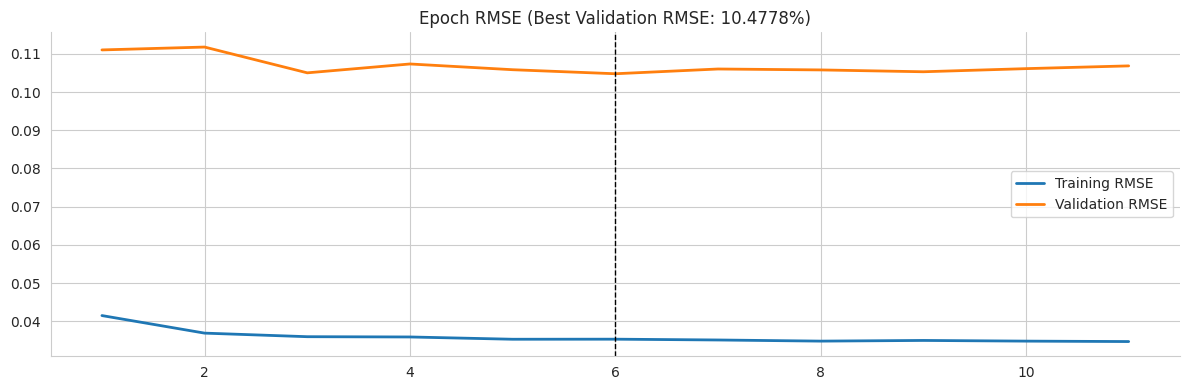

In [ ]:
loss_history_final=plot_rmse(lstm_training_final,filename='lstm_msft_error_20units')

In [ ]:
loss_history_final.to_csv('loss_history_20units.csv')
print(loss_history_final)

    Training RMSE  Validation RMSE
1        0.041511         0.111011
2        0.036915         0.111761
3        0.035981         0.105015
4        0.035911         0.107336
5        0.035314         0.105833
6        0.035332         0.104778
7        0.035121         0.106021
8        0.034825         0.105780
9        0.035003         0.105297
10       0.034823         0.106113
11       0.034711         0.106834


In [ ]:
train_rmse_scaled = np.sqrt(model_final.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(model_final.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0347 | Test RMSE: 0.1048


In [ ]:
train_predict_scaled = model_final.predict(X_train)
test_predict_scaled = model_final.predict(X_test)

16/16 [==============================] - 0s 8ms/step


In [ ]:
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.8621 | Test IC: 0.6105


##Rescale predictions

In [ ]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled)
                          .squeeze(), 
                          index=y_test.index))

In [ ]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [ ]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}'

'Train RMSE: 0.8084 | Test RMSE: 2.4405'

##Plot results

In [ ]:
# Create new_data_df
final_data_df=data_df.copy()
final_data_df['Train Predictions'] = train_predict
final_data_df['Test Predictions'] = test_predict

final_data_df = final_data_df.join(train_predict.to_frame('predictions').assign(data='Train')
                        .append(test_predict.to_frame('predictions').assign(data='Test')))


<ipython-input-34-04e786c0109a>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data_df = final_data_df.join(train_predict.to_frame('predictions').assign(data='Train')


<ipython-input-35-e18976e7ccb9>:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
<ipython-input-35-e18976e7ccb9>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)


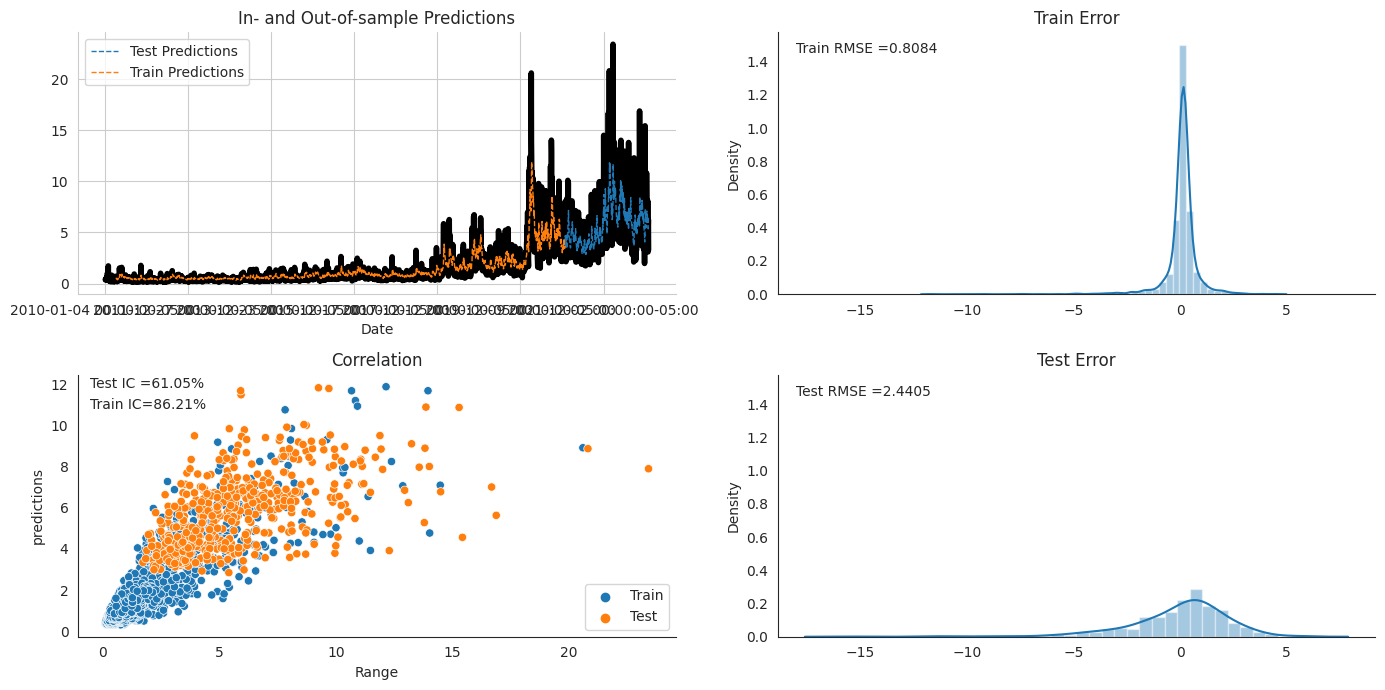

In [ ]:
df=final_data_df.copy()

#Plot results 
sns.set_style('whitegrid')
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)
##ax1
df.loc[:, 'Range'].plot(lw=4, ax=ax1, c='k')
df.loc[:, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')
##ax2,3,4
with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Range', y='predictions', data=df, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'lstm_msft_regression_20units', dpi=300)

16/16 [==============================] - 0s 8ms/step


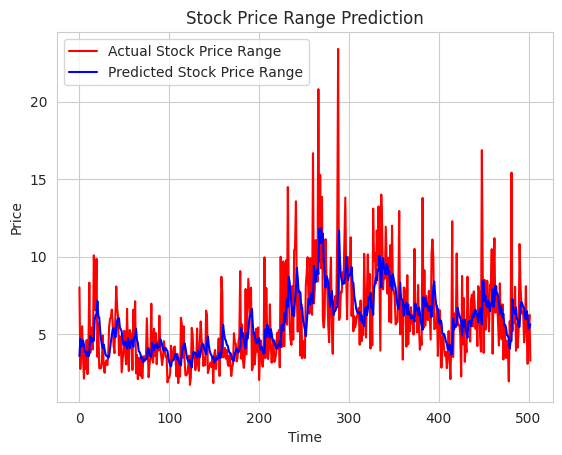

In [ ]:
plot_pred_without_date(model_final,scaler,X_test,y_test)

#Benchmark:LinearRegression model

##LinearRegression datasets generation

In [ ]:
# Set split dates
split_date_train = '2020-12-31'
split_date_test = '2021-01-01'

# Select training data
X_train_lr = X[:split_date_train].values
y_train_lr = y[:split_date_train]

# Select testing data
X_test_lr = X[split_date_test:].values
y_test_lr = y[split_date_test:]

print(X_train_lr.shape, y_train_lr.shape)
print(X_test_lr.shape, y_test_lr.shape)


(2705, 64) (2705,)
(503, 64) (503,)


##Train LinearRegression model

In [ ]:
# Create a linear regression model
model_lr = LinearRegression()

# Train the model on the train data
model_lr.fit(X_train_lr, y_train_lr)

LinearRegression()

##Evaluate LinearRegression model performance

In [ ]:
# Make predictions on train data and test data
train_predict_scaled_lr = model_lr.predict(X_train_lr)
test_predict_scaled_lr = model_lr.predict(X_test_lr)

# Calculate train RMSE and test RMSE
train_rmse_lr = np.sqrt(mean_squared_error(y_train_lr, train_predict_scaled_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test_lr, test_predict_scaled_lr))

# Print train RMSE and test RMSE
print(f'Train RMSE: {train_rmse_lr:.4f} | Test RMSE: {test_rmse_lr:.4f}')

Train RMSE: 0.0324 | Test RMSE: 0.1127


In [ ]:
#Calculate spearmanr
train_ic = spearmanr(y_train_lr, train_predict_scaled_lr)[0]
test_ic = spearmanr(y_test_lr, test_predict_scaled_lr)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.8456 | Test IC: 0.5355


##Rescale predictions

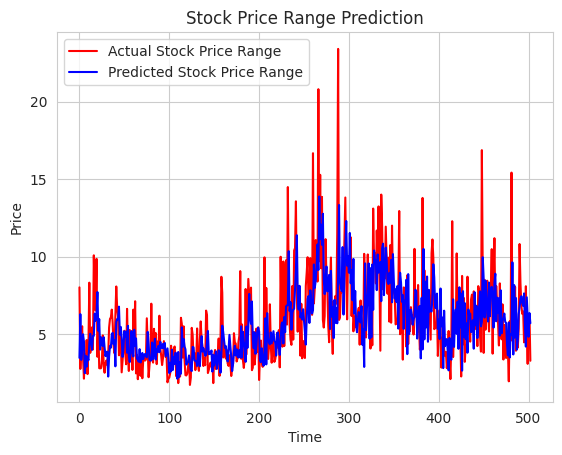

In [ ]:
# Rescaled test_predict_scaled (Predicted Stock Price Range)
y_pred_2d_lr = test_predict_scaled_lr.reshape(-1, 1)
y_pred_2d_rescaled_lr = scaler.inverse_transform(y_pred_2d_lr)

#Actual Stock Price Range
actual_stock_price_range_lr=scaler.inverse_transform(y_test_lr.values.reshape(-1, 1))

# Visualize the results without date information
plt.plot(actual_stock_price_range_lr, color='red', label='Actual Stock Price Range')
plt.plot(y_pred_2d_rescaled_lr, color='blue', label='Predicted Stock Price Range')
plt.title('Stock Price Range Prediction')
plt.xlabel('Time')
plt.ylabel('Price')

# Set the X-axis scale
n = 10  # Define the interval for the ticks, e.g., every 10 data points
ticks = np.arange(0, len(actual_stock_price_range_lr), 100)
plt.xticks(ticks)

plt.legend()
plt.show()


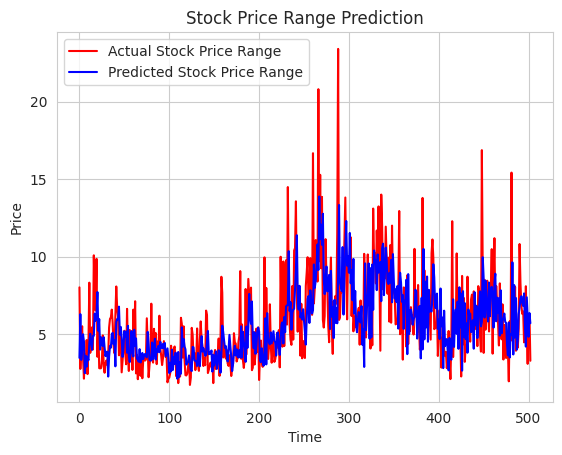

In [ ]:
# Rescaled test_predict_scaled (Predicted Stock Price Range)
y_pred_2d_lr = test_predict_scaled_lr.reshape(-1, 1)
y_pred_2d_rescaled_lr = scaler.inverse_transform(y_pred_2d_lr)

#Actual Stock Price Range
actual_stock_price_range_lr=scaler.inverse_transform(y_test_lr.values.reshape(-1, 1))

# Visualize the results wothout date information 
plt.plot(actual_stock_price_range_lr, color = 'red', label = 'Actual Stock Price Range')
plt.plot(y_pred_2d_rescaled_lr, color = 'blue', label = 'Predicted Stock Price Range')
plt.title('Stock Price Range Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
#Calculate Train RMSE and Test RMSE
train_predict_scaled_lr_2d = train_predict_scaled_lr.reshape(-1, 1)
test_predict_scaled_lr_2d_ = test_predict_scaled_lr.reshape(-1, 1)

train_predict_lr = pd.Series(scaler.inverse_transform(train_predict_scaled_lr_2d).squeeze(), index=y_train_lr.index)
test_predict_lr = (pd.Series(scaler.inverse_transform(test_predict_scaled_lr_2d_).squeeze(), index=y_test_lr.index))

y_train_rescaled_lr = scaler.inverse_transform(y_train_lr.to_frame()).squeeze()
y_test_rescaled_lr = scaler.inverse_transform(y_test_lr.to_frame()).squeeze()

train_rmse = np.sqrt(mean_squared_error(train_predict_lr, y_train_rescaled_lr))
test_rmse = np.sqrt(mean_squared_error(test_predict_lr, y_test_rescaled_lr))

#Output RMSE
f'Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}'

'Train RMSE: 0.7551 | Test RMSE: 2.6261'

##Plot results

In [ ]:
#Create lr_data_df
lr_data_df=data_df.copy()

lr_data_df['Train Predictions'] = train_predict_lr
lr_data_df['Test Predictions'] = test_predict_lr

lr_data_df = lr_data_df.join(train_predict.to_frame('predictions').assign(data='Train')
                            .append(test_predict.to_frame('predictions').assign(data='Test'))
                            )

<ipython-input-43-a7e2cf720470>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lr_data_df = lr_data_df.join(train_predict.to_frame('predictions').assign(data='Train')


<ipython-input-44-23481fd50093>:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
<ipython-input-44-23481fd50093>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)


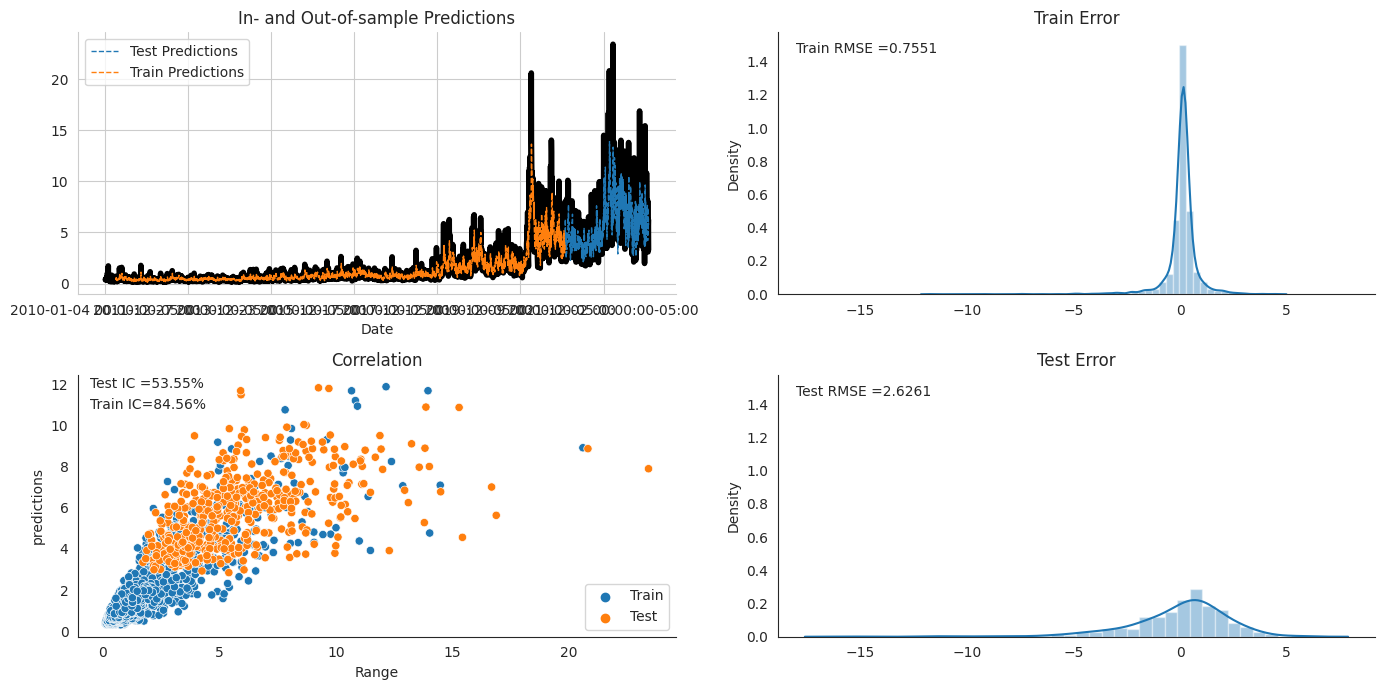

In [ ]:
df=lr_data_df.copy()

#Plot results
sns.set_style('whitegrid')
fig=plt.figure(figsize=(14,7))
##ax1
ax1 = plt.subplot(221)
df.loc[:, 'Range'].plot(lw=4, ax=ax1, c='k')
df.loc[:, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')
##ax2,ax3,ax4
with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Range', y='predictions', data=df, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'lr_msft_regression_benchmark', dpi=300)